In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import string
from top2vec import Top2Vec
import multiprocessing
from scipy.special import softmax
from wordcloud import WordCloud
import os

C:\Users\krister\py_projects\rz_acta\acta_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def define_plot_fonts():
    fm.fontManager.addfont('../references/cmunorm.ttf')
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rcParams['font.family'] = 'CMU Concrete'

In [3]:
df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8')
df.doc_date = pd.to_datetime(df.doc_date)
df.origin_date = pd.to_datetime(df.origin_date)
#df.delta = pd.to_timedelta(df.delta, unit='days')
df = df[df.delta.isin(range(0,120))]

In [4]:
rz = pd.read_parquet('../data/raw/RZ_processed.parquet')

In [6]:
t2v = Top2Vec.load('../data/models/t2v_171122_100_deep.pkl')

In [7]:
def custom_topic_wordcloud(top, savepath=None, show=True):
    
    cloudwidth = 2400
    cloudheight = 800
    
    topic_words = t2v.get_topics(reduced=True)[0][top]
    word_scores = t2v.get_topics(reduced=True)[1][top]
    
    topic_words_dict = dict(zip(topic_words, softmax(word_scores)))
    
    wc = WordCloud(background_color='white', width=cloudwidth, height=cloudheight,
                   font_path='../references/cmunrm.ttf')
    
    wc.generate_from_frequencies(topic_words_dict)
    
    plt.figure(figsize=(12, 4))
    plt.imshow(wc)
    plt.axis('off')
        
    plt.tight_layout()
    
    if savepath:
        plt.savefig(f'{savepath}\\{top}.png', bbox_inches='tight')
        
    if show == True:
        plt.show()

In [8]:
def get_topic_stats(top, savepath=None, show=True):
    
    topic_size = t2v.get_topic_sizes(reduced=True)[0][top]
    topic_document_ids = t2v.search_documents_by_topic(top, topic_size, reduced=True)[2]
    
    doc_ids = [int(ID.split('_')[1]) for ID in topic_document_ids]
    
    top_df = rz.loc[doc_ids]
    
    define_plot_fonts()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    top_df.year.hist(bins=87, ax=ax1)
    ax1.set_xlim(1802, 1889)
    
    top_df.heading2.value_counts()[:10].plot.bar(ax=ax2)
    ax2.set_xticklabels(labels=top_df.heading2.value_counts()[:10].index, rotation=45, ha='right')
    
    #plt.tight_layout()
    
    if savepath:
        plt.savefig(f'{savepath}\\topic_{str(top)}.png', bbox_inches='tight')
    
    if show == True:
        plt.show()

In [51]:
def get_topic_examples(top, n, savepath=None):
    
    examples = t2v.search_documents_by_topic(top, n, reduced=True)[2]
    
    msg_ids = [int(ex.split('_')[0]) for ex in examples]
    doc_ids = [int(ex.split('_')[1]) for ex in examples]
    
    example_texts = []
    
    for msg_id, doc_id in zip(msg_ids, doc_ids):
        article = df.loc[df.doc_id == doc_id]
        #print(article) # delete
        
        if len(article) == 1 or article.index[-1] == msg_id:
            span_start = article.start.values[0]
            span_end = -1

        elif len(article) > 1:
            span_start = article.loc[msg_id, 'start']
            span_end = article.loc[msg_id+1, 'start']
            
        example_texts.append(
                                {"msg_id": msg_id,
                                 "doc_id": doc_id,
                                 "date": rz.loc[doc_id, 'date'],
                                 "heading": rz.loc[doc_id, 'heading'],
                                 "text": rz.loc[doc_id, 'full_text'][span_start:span_end]
                                }
                            )
        
    print(f'Found {len(example_texts)} examples for topic {top}')
    
    if savepath:
        with open(savepath+f'\\examples_{top}.json', 'w', encoding='utf8') as f:
            json.dump(example_texts, f)
            
    else:
        assert len(example_texts) == n
        return example_texts

In [45]:
def get_topic_sizes(reduction):
    
    sizes = [int(s) for s in t2v.get_topic_sizes(reduced=True)[0]]
    assert len(sizes) == reduction
    
    with open(f'../streamlit/data/topics/reduction_{str(reduction)}/sizes.json', 'w', encoding='utf8') as f:
        json.dump(sizes, f)

In [42]:
def create_topic_data_for_streamlit(t2v, reduction, model_path=None, reduce=True):
    
    if model_path:
        print('Loading model')
        t2v = Top2Vec.load(model_path)
    
    directory = f'C:\\Users\\krister\\py_projects\\rz_acta\\streamlit\\data\\topics\\reduction_{reduction}'    
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    if reduce:
        print(f'Performing reduction to {reduction} topics')
        t2v.hierarchical_topic_reduction(reduction)
        
    assert t2v.get_num_topics(reduced=True) == reduction
    
    print('Generating wordclouds')
    if not os.path.exists(directory+'\\wordclouds'):
        os.mkdir(directory+'\\wordclouds')
        
    for top in tqdm(range(reduction)):
        custom_topic_wordcloud(top, show=False, savepath=directory+'\\wordclouds')
        
    
    print('Generating statistics')
    if not os.path.exists(directory+'\\statistics'):
        os.mkdir(directory+'\\statistics')
        
    for top in tqdm(range(reduction)):
        get_topic_stats(top, show=False, savepath=directory+'\\statistics')
        
        
    print('Fetching examples')
    if not os.path.exists(directory+'\\examples'):
        os.mkdir(directory+'\\examples')
        
    for top in tqdm(range(reduction)):
        get_topic_examples(top, 20, directory+'\\examples')
        
    del t2v
          
    print('Finished')

In [184]:
def create_topics_df():
    
    data = []
    
    for ID in t2v.document_ids:
        msg_id, doc_id = [int(ix) for ix in ID.split('_')]
        topics, scores = t2v.get_documents_topics([ID], reduced=True)[0:2]
        
        if len(topics) > 1:
            topics = ' ,'.join([str(top) for top in topics])
        else:
            topics = topics[0]
            
        if len(scores) > 1:
            scores = ' ,'.join([str(sco) for sco in scores])
        else:
            scores = scores[0]
            
        
        data.append([msg_id, doc_id, topics, scores])
        
    return pd.DataFrame(data, index=t2v.document_ids, columns=['msg_id', 'doc_id', 'topics', 'scores'])

In [185]:
topics_df = create_topics_df()

In [44]:
with open('../data/spans_tokenized.json', 'r', encoding='utf8') as f:
    spans_tok = json.load(f)

In [46]:
spans_tok[-1]

{'msg_id': 226083,
 'doc_id': 289704,
 'tokens': ['budget',
  'veröffentlicht',
  'wo.den',
  'darnach',
  'betragen',
  'ordentlichen',
  'einnahmen',
  'transitorische',
  'außerordentliche',
  'freie',
  'baarschaft',
  'reichskaffen',
  'gesammteinnahmen',
  'demnach',
  'mill',
  'ordentlichen',
  'ausgaben',
  'betragen',
  'tranfitorischen',
  'auß?rordent',
  'ichen',
  'ffür',
  'eisenbahnen',
  'häfen',
  'g-sammtausgaben',
  'betragen',
  'demnach',
  'ordentlichen',
  'sinnahmen',
  'übersteigen',
  'somit',
  'ordentlichen',
  'ausgaben',
  'mill',
  'rowoje',
  'wrema',
  'wiffen',
  'oesterreich-ungarn',
  'kurzem',
  'türkei',
  'übereingekommen',
  'nunmehr',
  'theil',
  'sandshaks',
  'nowl-ba.ar',
  'besetzen',
  'berliner',
  'vertröge',
  'stipulirt',
  'oceupation',
  'sandshaks',
  'beiderseitiger',
  'verständigung',
  'erfolgen',
  'oesterreich-ungarn',
  'theil',
  'besetzt',
  'nord',
  'berlin',
  'januar',
  'december',
  'prinz',
  'friedrich',
  'leopold

In [ ]:
t2v.model.

In [80]:
import umap
import seaborn as sns
import colorcet as cc

In [85]:
def plot_umap(model, reduction, exceptions=[], topic_names=None, savepath=None, **kwargs):
    
    print(f'Reducing topics to {reduction}')
    t2v.hierarchical_topic_reduction(reduction)
    
    print('Fetching IDs')
    relevant_ids = [doc_id for doc_id, top in
                    zip(t2v.document_ids, t2v.get_documents_topics(t2v.document_ids, reduced=True)[0])
                    if top not in exceptions]
    
    print('Fetching vectors')
    relevant_vectors = [vec for vec, top in
                        zip(t2v.document_vectors, t2v.get_documents_topics(t2v.document_ids, reduced=True)[0])
                        if top not in exceptions]
    
    print('Creating DataFrame')
    topic_vector_df = pd.DataFrame(index=relevant_ids, columns=range(1,301),
                                   data=relevant_vectors)
    
    print('Performing UMAP dimensional reduction')
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    main_topics = t2v.get_documents_topics(relevant_ids, reduced=True)[0]
    umap_df['topic'] = main_topics
    umap_df = umap_df.sort_values(by='topic')
    if topic_names:
        umap_df['topic'].replace(topic_names, inplace=True)
        
    return umap_df
    
    print('Plotting')
    plt.figure(figsize=(24, 24))
    
    sns.scatterplot(data=umap_df, x='x', y='y', hue='topic', **kwargs,
            palette=sns.color_palette(cc.glasbey_light, n_colors=len(umap_df.topic.unique())))
    
    plt.legend(ncol=2, markerscale=1, fontsize=14)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()

In [86]:
umap_df = plot_umap(t2v, 30)

Reducing topics to 30
Fetching IDs
Fetching vectors
Creating DataFrame
Performing UMAP dimensional reduction


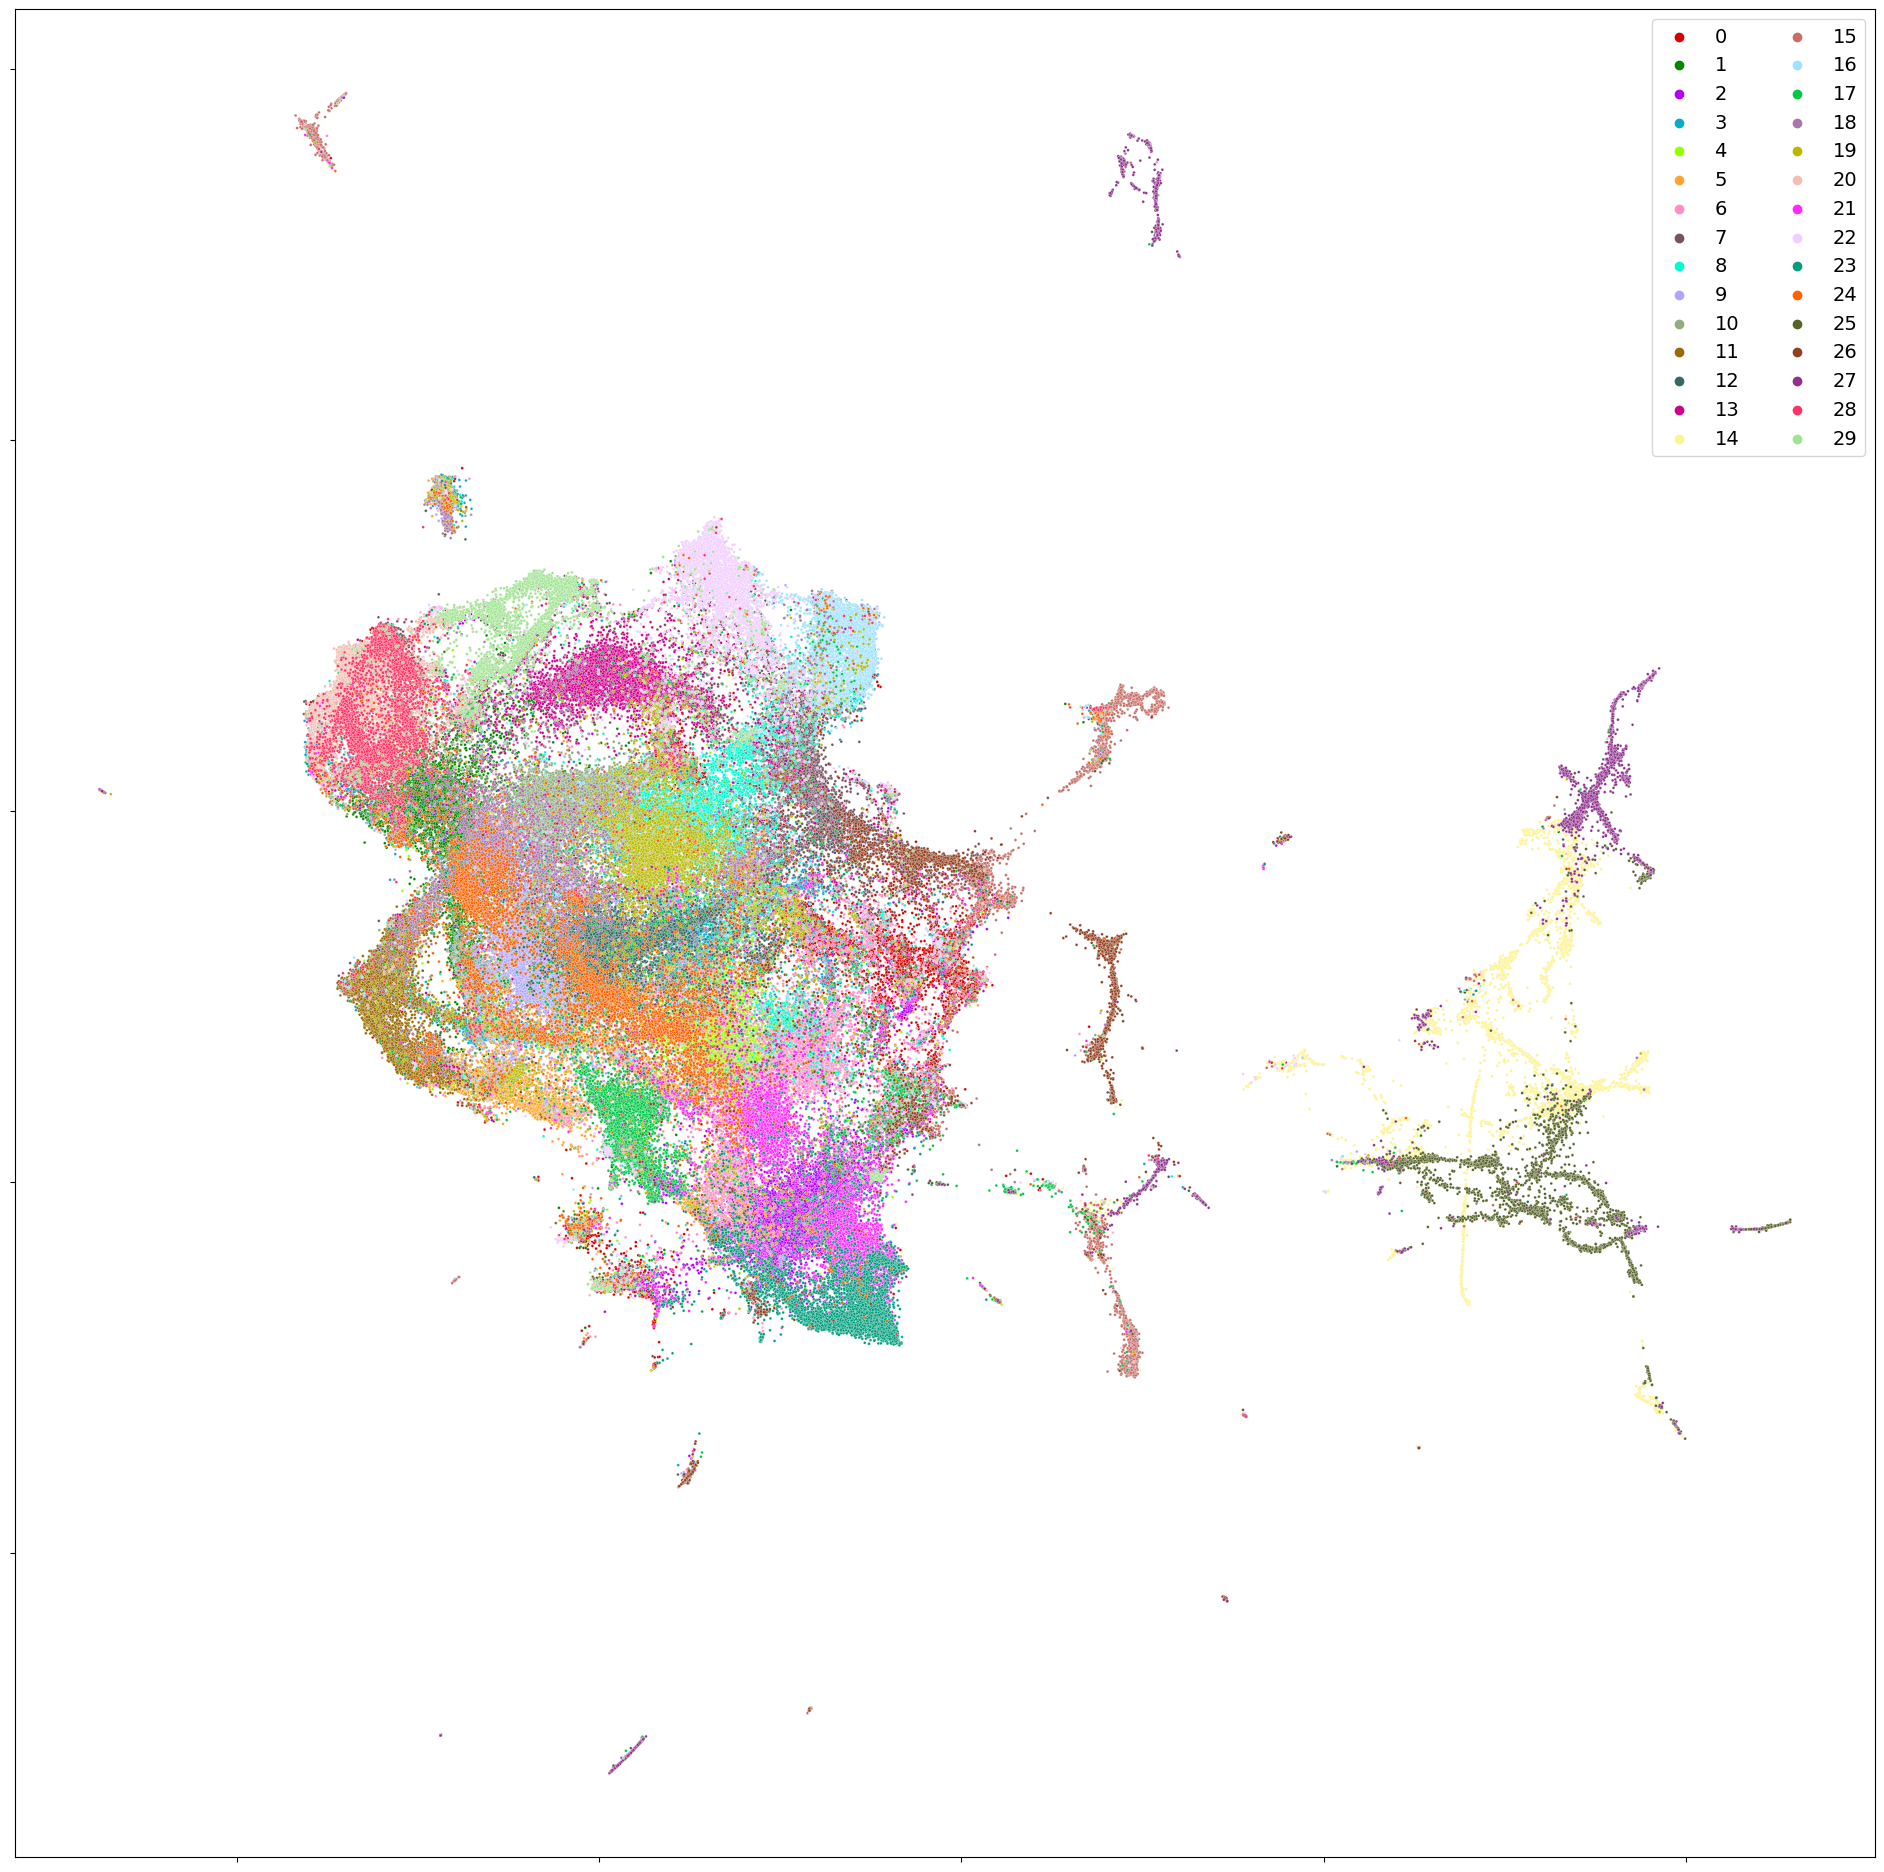

In [88]:
plt.figure(figsize=(24, 24))

sns.scatterplot(data=umap_df, x='x', y='y', hue='topic', s=4,
        palette=sns.color_palette(cc.glasbey_light, n_colors=len(umap_df.topic.unique())))

plt.legend(ncol=2, markerscale=1, fontsize=14)
plt.grid(False)
plt.xlabel(None)
plt.ylabel(None)
plt.gca().yaxis.set_ticklabels([])
plt.gca().xaxis.set_ticklabels([])

#if savepath:
#    plt.savefig(savepath, bbox_inches='tight')
    
plt.show()

In [98]:
def get_text_lengths(df):
    
    # only articles that contain > 2 placenames/dates
    df = df.loc[df.doc_id.isin(df.doc_id.value_counts()[lambda x: x > 1].index)]
    
    lengths = []
    
    # lengths = df.groupby('doc_id').apply(lambda x: x['start'] - x['end'].shift(1)).fillna(pd.NA).reset_index(drop=True).dropna()

    for ix in tqdm(df.doc_id.unique()):
        article = df.loc[df.doc_id == ix]
        for start, end in zip(article.start.iloc[1:], article.end.iloc[:-1]):
            lengths.append(start-stop)
            
    return lengths

In [99]:
lengths = get_text_lengths(df)

100%|███████████████████████████████████████████████████████████████████████████| 39948/39948 [01:06<00:00, 600.85it/s]


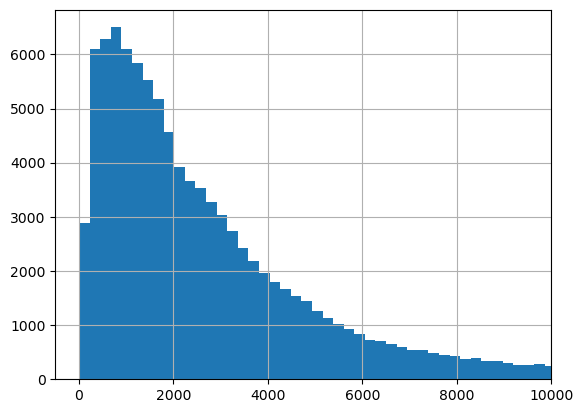

In [114]:
pd.Series(lengths).hist(bins=300)
plt.xlim(-500, 10000)
plt.show()

In [5]:
def get_sample():
    
    sample_doc_id = df.doc_id.sample().values[0]
    
    print(df.loc[df.doc_id == sample_doc_id, 'placename'].values, '\n\n')
    print(df.loc[df.doc_id == sample_doc_id, 'doc_date'].dt.year.values[0], '\n\n')
    print(rz.loc[sample_doc_id, 'heading'], '\n------------')
    print(rz.loc[sample_doc_id, 'full_text'])

In [32]:
get_sample()

['London' 'London'] 


1857 


Groszbritannien und Irland. 
------------
Groszbritannien und Irland.

	London, 1. Juli. (N. Pr. Z.) Die Sammlungen zu Ehren der freiwilligen Krankenpflegerin im Krimkriege, Miß Nlghtingale, find I mit einer Summe von 300.000 Thlrn. geschlossen worden. Es soll dafür ein Hospital unter ihrer Leitung gestiftet werden.
London, 2. Juli. (St.-A ) Ihre Majestät die Königin, der Prinz-Gemadl und die Königliche Familie begaben fich gestern früh zur Kunst.AuSstellung von WorSley nach Manchester und find heute Nach- ■ mittag von dort nach London zurückgekehrt. — Der Prinz Friedrich \ Wilhelm von Preußen nahm gestern in Begleitung des Prinzen ! Albert, des Prinzen von WaleS, des Prinzen Alfred, des Preußischen | Gesandten und mehrer Herren seines Gefolges folgende Beglück- , wünschungS.Adresse deS GemeinderalhS von Manchester in Empfang: i „An Se. K. H. den Prinzen Friedrich Wilhelm von Preußen. Ge- \ ruhen Ew. K. H. zu erlauben, daß wir — der Mayor, die Aldermen \ 